# **<center>SDSC3006 Lab : Shrinkage Methods</center>**

TA : Nathanael Tepakbong (Nath)  
Email : ntepakbo-c@my.cityu.edu.hk  
Source material : https://www.statlearning.com/

### Importing the necessary packages :

**WARNING :** In this lab, we use the ``l0bnb`` library, which can create some dependencies conflicts. The below line of code ensures that all packages are installed together, avoiding potential clashes. If you run this on your personal laptop, create a new conda environment and add all of these packages at the creation of the environment.

In [1]:
!pip install ISLP==0.3.19 l0bnb numpy==1.23.5 numba

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

And we add the imports which we will specifically need for this lab. Among which is the package ``l0bnb`` which is optimized to solve large-scale $L_0$-norm penalized regression.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

In [4]:
from l0bnb import fit_path

## I - Subset Selection Methods :

We will first look at methods to reduce the number of parameters by restricting the model to a subset of the input variables.

### I.1 - Forward Selection

We will apply the forward selection approach to the ``Hitters`` dataset : the goal is to predict a player's ``Salary`` based on certain statistics related to their performance in the previous year.

In [5]:
Hitters = load_data('Hitters')
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


Note that there are players for which the ``Salary`` variable is missing. We may identify these with the ``numpy`` function ``np.isnan()``. Feel free to consult its documentation to see how it works.

In [6]:
nan_list = np.isnan(Hitters.Salary)
nan_list

0       True
1      False
2      False
3      False
4      False
       ...  
317    False
318    False
319    False
320    False
321    False
Name: Salary, Length: 322, dtype: bool

In [7]:
nan_list.sum()

59

$59$ out of $322$ entries of our dataset are corrupted, that's unfortunate. We will have to drop them as they can not be used to train our model. To do so we use the method ``dropna`` directly on the ``Hitters`` dataframe.

In [8]:
Hitters = Hitters.dropna()
Hitters.shape #check that the NA lines have been dropped

(263, 20)

We will choose the best model using forward selection based on the $C_p$ MSE estimate, defined for a least square model with $d$ predictors as
$$C_p := \frac1n\left(RSS + 2d\hat{\sigma}^2\right) $$
This score is not built into ``sklearn`` or any other library we're using, so we create our own function to use a scorer.  

*Note* : by default, ``sklearn`` tries to maximize scores, hence we will define our score as $-C_p$, since we want to minimize it.

In [9]:
def nCp(sigma2 , estimator , X, Y):
    #Negative Cp statistic
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

We still need to estimate the variance term $\sigma^2$, i.e. compute $\hat{\sigma}^2$, to be used as an argument in our function ``nCp``. To do so we will fit a linear model using all available variables and take its MSE as $\hat{\sigma}^2$.

In [10]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale
sigma2

99591.35617968219

The function ``sklearn_selected`` expects a scorer with only three arguments as input, hence we will us the function ``partial`` from the ``functools`` module to freeze the first argument with our estimate ``sigma2`` we just computed.

In [11]:
neg_Cp = partial(nCp , sigma2)

Now that we have defined ``neg_Cp`` as our scorer, we need to define a search strategy. This can be done using the ``Stepwise`` object in the ``ISLP.models`` package, which contains different search strategies that can be specified to the model. For instance, the method ``Stepwise.first_peak()`` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score. Similarly, the method ``Stepwise.fixed_steps()`` runs a fixed number of steps of stepwise search.

In [12]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

We are now ready to fit a linear model to the outcome variable ``Salary``, using ``strategy`` we just defined as a forward selection method and $C_p$ as a scorer.

In [13]:
hitters_MSE = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_MSE.fit(Hitters , Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

If we do not specify a ``scoring`` argument, the MSE is used and so all variables are chosen. See for comparison :

In [14]:
hitters_MSE = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_MSE.fit(Hitters , Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### I.2 - Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an alternative to $C_p$, we can try cross-validation to select a model in forward selection : we store each model found in the full forward path, and evaluate each of these models, after which we can perform cross-validation on these models.

In [15]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS , strategy)

We now fit the ``Hitters`` data for each model in the forward selection path and compute the output on each model

In [16]:
full_path.fit(Hitters , Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

We get an array of fixed values : there are 20 steps in total, corresponding to the 19 features + the null model (just output the mean). We can evaluate the in-sample MSE for each of these models and see how it evolves as we increase the number of parameters. We will plot it using the ``matplotlib`` library.

(50000.0, 250000.0)

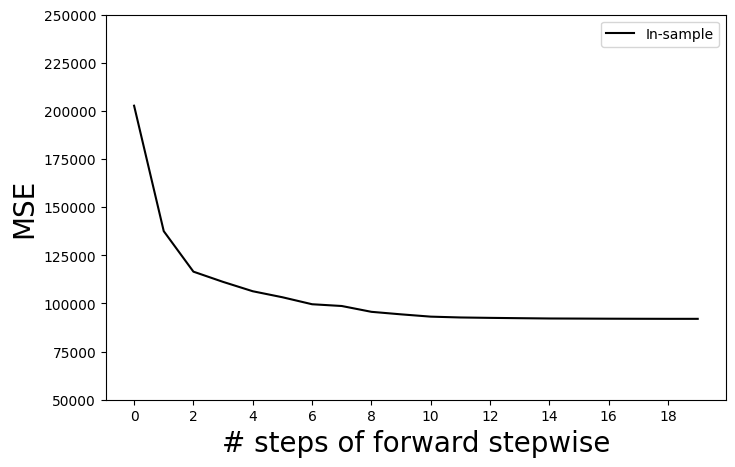

In [17]:
mse_fig , ax = subplots(figsize=(8,5))

insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]

ax.plot(np.arange(n_steps), insample_mse,
'k', # color black
label='In-sample')

ax.set_ylabel('MSE',fontsize=20)
ax.set_xlabel('# steps of forward stepwise',fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim ([50000 ,250000])

As expected, the in-sample MSE decreases when we use more variables to fit the model. We will thus need cross-validation to decide how many parameters we actually need.

We will thus perform $K$-fold cross-validation and evaluate the MSE of each model on **training data** :

In [18]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path , Hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

See how ``Yhat_cv`` has the same dimensions as ``Yhat_in`` ? The (big) difference is that in each row of ``Yhat_cv``, the prediction is made based on a training dataset which did not contain that row.  

Now to compute the cross-validated MSE for each model in the path, we compute, for each model, the MSE on each of the folds, and we average them. **Task :** read the below code carefully and make sure you understand what it does !

In [19]:
cv_mse = []
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx ,None])**2
    cv_mse.append(errors.mean(0)) # column means

cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

Now we add the cross validated scores to the in-sample MSE plot we previously had :

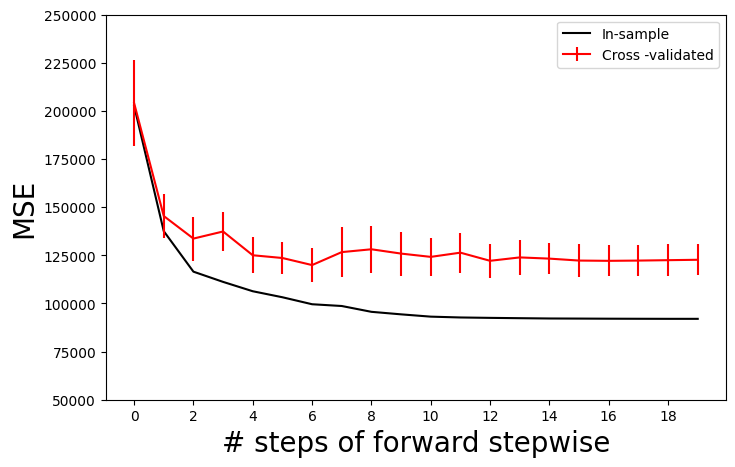

In [20]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1) / np.sqrt(K),
            label='Cross -validated',
            c='r') # color red
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

We can now repeat the same thing with a validation set, which is very similar to what was previously done except only one MSE is computed instead of ``K`` now. We will use a validation set of size $20\%$ of the original dataset, similar to what we get when using a $K$-fold with $K=5$.  

**Task :** read the below code careuflly and make sure you understand what it does !

In [21]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_idx , test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx ,None])**2
    validation_mse = errors.mean(0)

Again, we plot the in-sample MSE against the one on the validation set for each model in the path. Note that because we only have one prediction instead of ``K``, we do not have a confidence interval anymore.

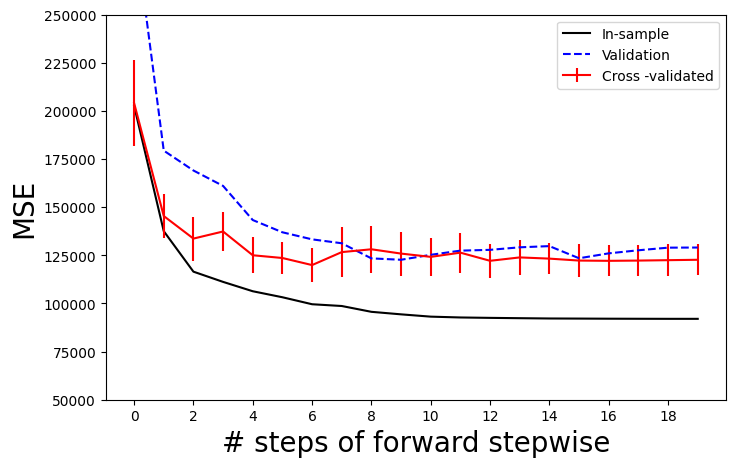

In [22]:
ax.plot(np.arange(n_steps), validation_mse ,
    'b--', # color blue, broken line
    label='Validation')

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

### I.3 - Best Subset Selection

Forward stepwise selection is a so-called *greedy* selection method : it augments the number of variables by one at each step. We will now implement instead the *best* subset selection method, which for a given number of predictors $n$, selects the best subset of predictors of size $n$.  

To do so we will use the ``l0bnb`` package which produces a path of solutions while penalizing the subset size (hence we have an *implicit* rather than *explicit* constraint on the subset size)

In [23]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1) #10bnb fits the intercept separately
X = np.asarray(D)

We can find a path using the ``fit_path`` function :

In [24]:
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


The output of this function is a list, where the index ``i`` corresponds to the ``i+1``-th step of the path, and the value at ``path[i]``gives the fitted coefficients as `B`, intercept as `B_0` and regularization parameter as ``lambda_0``.  

For instance, here is the best model at the fourth step :

In [25]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

And at the 12th step :

In [26]:
path[11]

{'B': array([  -1.20831273,    4.64432264,    0.        ,    0.        ,
           0.        ,    4.59805059,  -11.6699466 ,    0.        ,
           0.        ,    0.        ,    0.58710796,    0.54935239,
          -0.45671348,    0.        , -126.39657952,    0.26498974,
           0.        ,    0.        ,    0.        ]),
 'B0': 131.78366110767536,
 'lambda_0': 0.0005480887274838073,
 'M': 0.5574849768321161,
 'Time_exceeded': False}

**Task :** What are ``M`` and ``Time_exceeded`` ? Based on the output of the best subset selection method, which predictors should we select to fit the model ?

**Task :** Summarize the above discussion regarding the subset selection method : what are the advantages and drawbacks of each the introduced methods ? In your opinion, which is best for the ``Hitters`` dataset ? Which one would you use if your dataset had a large number of samples ? What about if it had a large number of variables ?

## II - Ridge regression and the Lasso :

### II.1 - Ridge Regression

As before, we will fit a path of regression models using the ``skl.ElasticNet.path()`` function. It can be used to fit both Ridge and Lasso as we will see. Remember that we will need to standardize the data ``X`` before fitting it. However if we want coefficients for the unstandardized model, we will need to unstandardize them afterwards.

In [27]:
Xs = X - X.mean(0)[None ,:] #center the data
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:] #standardize the data

lambdas = 10**np.linspace(8, -2, 100) / Y.std() #values of regularization parameter, from 10^8 to 0.01
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1]
soln_array.shape

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did n

(19, 100)

For each value of regression parameter $\lambda$ ``lambdas[i]``, there is a vector of ridge regression coefficients given by ``soln_array[:,i]``. To make visualization easier, we transpose the matrix

In [28]:
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


We can also plot the paths as functions of $\lambda$ to see how the coefficients change was $\lambda$ changes

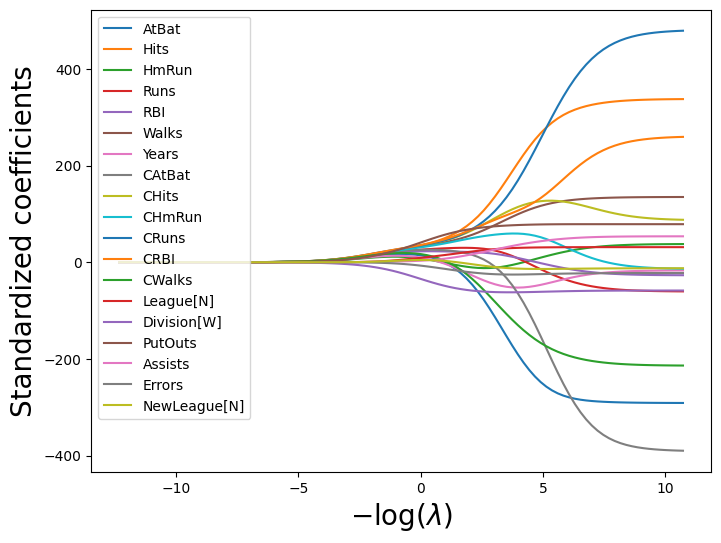

In [29]:
path_fig , ax = subplots(figsize=(8,6))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

**Task :** does this curve make sense ? Why ?

We can display the coefficients at the 40th step, in which case $\lambda \approx 25.35$

In [30]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

We can check the $\ell_2$ norm of the coefficients for this value of $\lambda$ :

In [31]:
np.linalg.norm(beta_hat)

24.17061720144378

For comparision, here is what we get when $\lambda \approx 0.244$

In [32]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725912)

In the above, we normalized ``X`` "by hand" and fit the data using ``Xs``. Actually, the ``Pipeline()`` object in ``sklearn`` provides a way to separate feature normalization from model fitting.

In [33]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)
np.linalg.norm(ridge.coef_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


160.42371017725904

As we see, we get the same $\ell_2$ norm as the fit obtained with our manually standardized data.

### II.2 - Estimating Test Error of Ridge Regression

When performing ridge regression, a critical aspect is to figure out which regularization parameter $\lambda$ to use. A perfect tool for this (a priori difficult) task is again cross validation.

In [34]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
ridge.alpha = 0.01

results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error',
cv=validation)
-results['test_score']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

So we get a MSE of $\approx 1.3\times10^5 $ for parameter $\lambda = 0.01$. For comparison, the most basic model would be to predict the mean of the observations. We can emulate such a model by fitting a ridge regression with parameter $\lambda\to\infty$ (**Task :** why ?) and compare their respective MSE :

In [35]:
ridge.alpha = 1e10 #=10^10

results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error',
cv=validation)
-results['test_score']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

The mean prediction model gets an MSE which is 10 times larger, so we see that the model with $\lambda =0.01$ performs (much) better on this instance. However the choice $\lambda =0.01$ was arbitrary, so what we can do is perform make a *grid* of parameters $\lambda$ and pick the one with the best performance. Here is what we get if we use the validation set approach :

In [36]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe, param_grid , cv=validation,
scoring='neg_mean_squared_error')

grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

Or we can use $5$-fold cross-validation :

In [37]:
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold,
scoring='neg_mean_squared_error')

grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

**Task :** Between the validation set and $5$-fold cross-validation, which one would be more reliable to select $\lambda$ ? Why ?

We can also plot the MSE as a function $\lambda$ (we will use $-\log(\lambda)$ instead to make visualization feasible)

Text(0, 0.5, 'Cross -validated MSE')

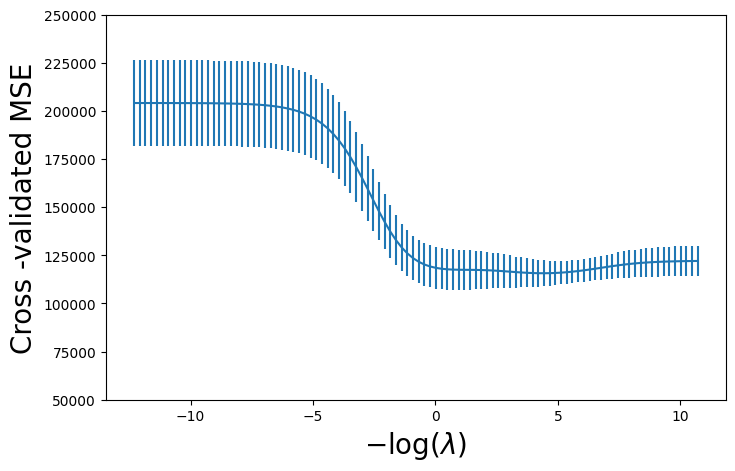

In [38]:
ridge_fig , ax = subplots(figsize=(8,5))
ax.errorbar(-np.log(lambdas), -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))

ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)

Although we've been cross-validating the MSE to choose a parameter, other metrics are possible as well. For instance, the default metric for ``skl.ElasticNet()``is the test $R^2$ coefficient. Let's see how it is affected by $\lambda$ as well

In [39]:
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X, Y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Text(0, 0.5, 'Cross -validated $R^2$')

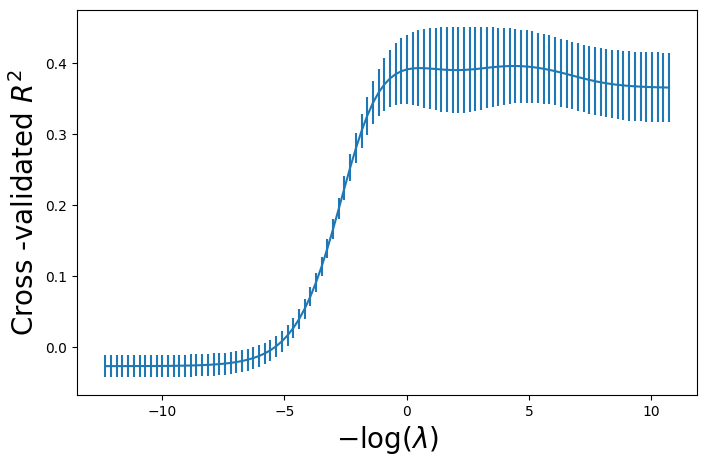

In [40]:
r2_fig , ax = subplots(figsize=(8,5))
ax.errorbar(-np.log(lambdas), grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated $R^2$', fontsize=20)

**Task :** Comment on the difference between the two plots

### II.3 - Fast Cross-Validation for Solution Paths

``sklearn`` actually provides a pipeline to perform cross-validation over a grid, or *path* of $\lambda$ values. We can use and plot the result to see that it is essentially a faster implementation of our ``grid`` approach above.

In [41]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795326.355502333, tolerance: 3759.109166869193
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross -validated MSE')

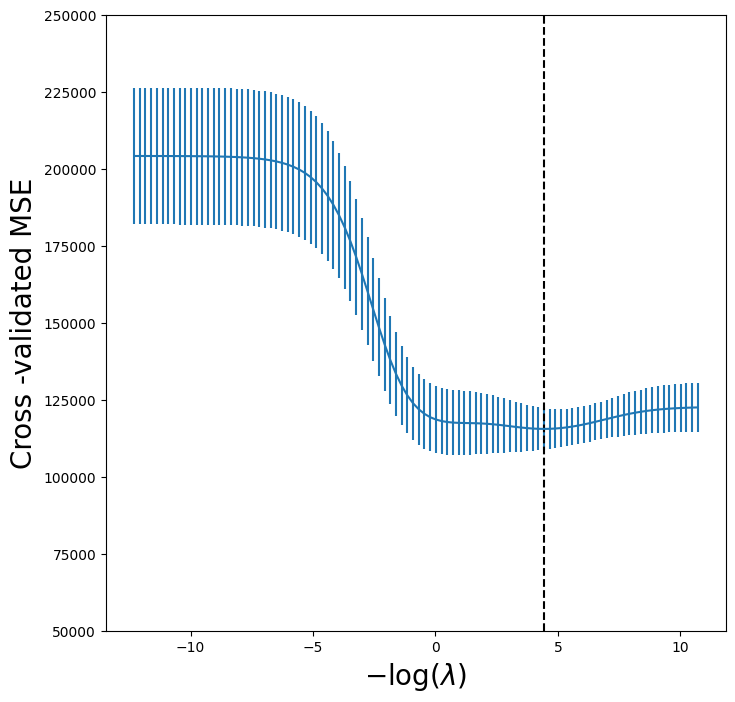

In [42]:
#plot
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)

In [43]:
tuned_ridge.alpha_,tuned_ridge.coef_

(0.01185247763144249,
 array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
           3.64888723,  108.90953869,  -50.81896152, -105.15731984,
         122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
        -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
          40.07350744,  -25.02151514,  -13.68429544]))

In [44]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987729

### II.4 - Evaluating Test Error of Cross-Validated Ridge  

Note that we chose $\lambda$ using $K$-fold cross-validation. Which implies that the model, which depends on $\lambda$, will have seen *all* of the dataset, i.e. nothing is left to compute the test MSE with !  

Therefore we fix it by doing an initial split of the data into a training and testing set, and the cross-validation approach to choose $\lambda$ is performed on the training set only.

In [45]:
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)

ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])

results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid,
                            scoring='neg_mean_squared_error')
-results['test_score']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.89304734, tolerance: 3200.6325551004934
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did

array([132393.84003227])

### II.5 - The Lasso

We saw that ridge regression with a well chosen $\lambda$ can outperform OLS regression on the ``Hitters`` dataset. Now we want to see how well Lasso does in comparison. To fit a Lasso model, we can reuse essentially the same code with the ``ElasticNetCV()`` function, except now we set ``l1_ratio=1``

In [46]:
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                    ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [47]:
lambdas , soln_array = skl.Lasso.path(Xs, Y, l1_ratio=1, n_alphas =100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=D.columns,
                            index=-np.log(lambdas))

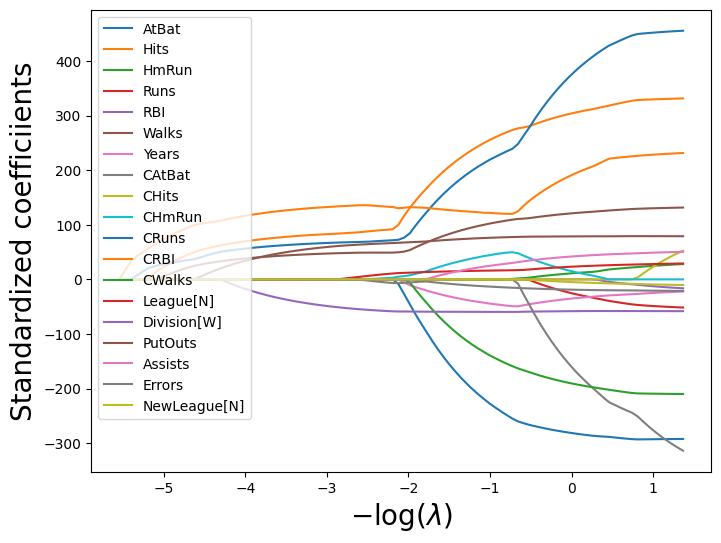

In [48]:
path_fig , ax = subplots(figsize=(8,6))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

**Task :** Comment this plot compared to the equivalent ridge regression plot.

Similarly, we can plot the cross-validation error evolution with $\lambda$

Text(0, 0.5, 'Cross -validated MSE')

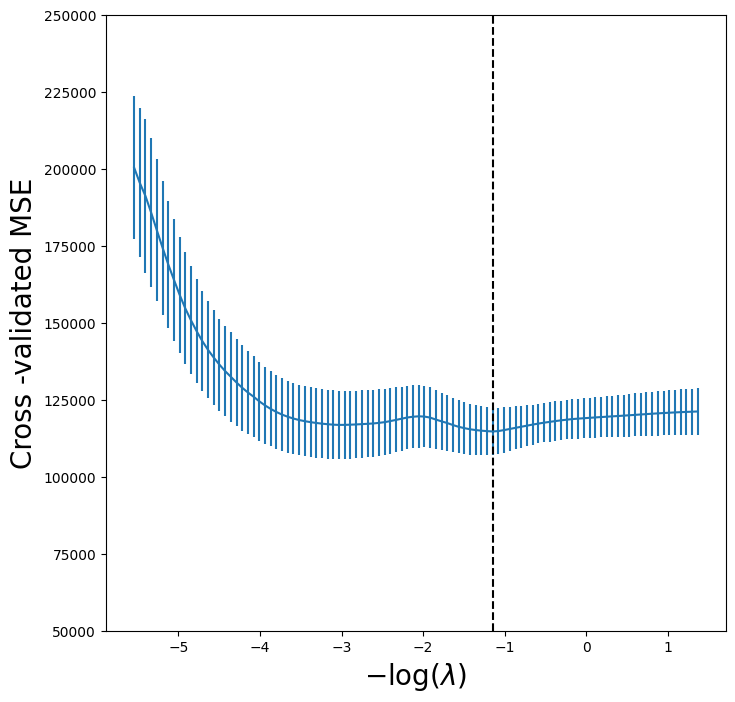

In [49]:
lassoCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
                tuned_lasso.mse_path_.mean(1),
                yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)

In [50]:
#minimum MSE
min(tuned_lasso.mse_path_.mean(1))

114690.73118253653

Overall, the behaviour of Lasso is similar to that of Ridge, and even the computed minimal MSE is similar. The main advantage of Lasso over Ridge regression however is that **it induces sparsity in the coefficients**

In [51]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

**Task :** Summarize the advantages and drawbacks of Lasso and Ridge in view of their performance on the ``Hitters`` dataset. Which one would you use ? What if the dataset has many samples ? What if the dataset has many parameters ?

## III - PCR and PLS Regression

### III.1 - Principal Components Regression

The idea of PCR is to transform the dataset into a lower dimensional representation using Principal Component Analysis, and perform regression on the lower dimensional features. We can use ``PCA()`` from ``sklearn.decomposition`` to perform PCA, and fit the resulting lower dimensional dataset with ``OLS()`` or ``LinearRegression()``.

In [52]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()

pipe = Pipeline([('pca', pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

PCA being scale dependent, the output will depend on whether or not we've standardized our data. In general, it's always a good practice to standardize the data, so we standardize it by modifying our pipeline :

In [53]:
pipe = Pipeline([('scaler', scaler),
                ('pca', pca),
                ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

Here we chose ``n_components = 2``, but of course there is no particular reason to. As before, the number of components is an *hyperparameter* of the model and the best way to chose it is by using cross-validation :

In [54]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

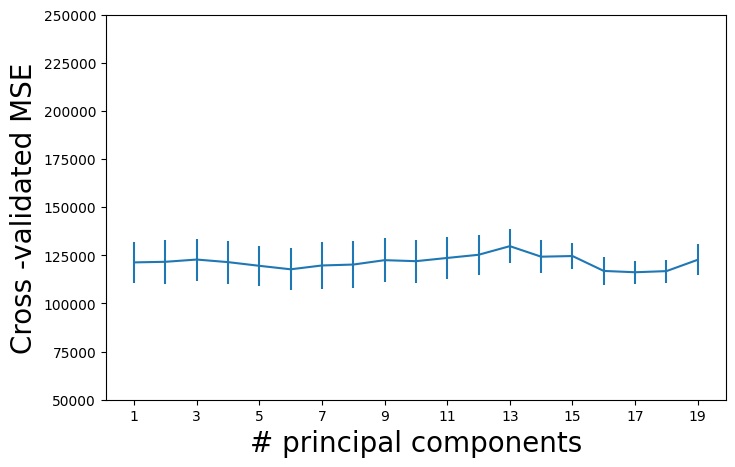

In [55]:
#plot
pcr_fig , ax = subplots(figsize=(8,5))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp , -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2])
ax.set_ylim ([50000 ,250000])

Here we see the the MSE doesn't vary much as the number of principal components, suggesting that a small number of principal components may suffice to build a reasonable model of the data.

**Task :** Implement $K$-fold cross-validation to find the best possible ``n_components``.

### III.2 - Partial Least Squares Regression  

Lastly, we briefly show how to implement Partial Least Square regression using the ``PLSRegression()`` function.

In [56]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X, Y)

PLSRegression()

Again, we will use cross validation to choose the number of components :

In [57]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls, param_grid, cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

And lastly we plot the evolution of the MSE :

(50000.0, 250000.0)

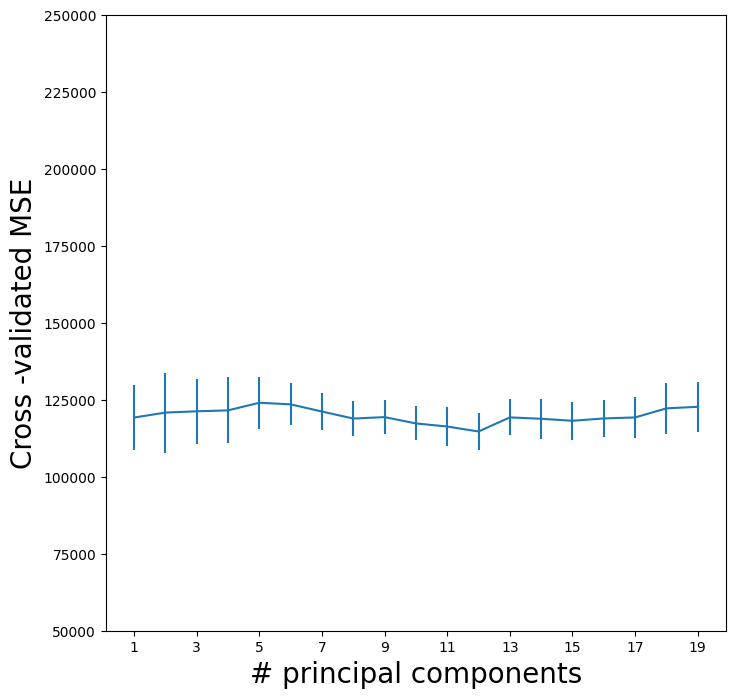

In [58]:
pls_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2])
ax.set_ylim ([50000 ,250000])

**Task :** Again, implement $K$-fold cross-validation to find the best possible ``n_components``.